In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import igraph
from supervenn import supervenn

In [2]:
data = pd.read_csv('../data/transport_traffic.csv')

In [3]:
data.head()

,transport,departure,arrival,passengers
0,avia,Москва,Симферополь (Крым),159441
1,avia,Москва,Сочи,149299
2,avia,Симферополь (Крым),Москва,155822
3,avia,Сочи,Москва,143298
4,avia,Санкт-Петербург,Москва,135749


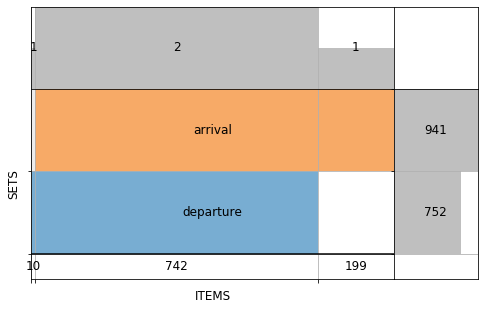

In [4]:
sets = [set(data['departure'].unique()), set(data['arrival'].unique())]
supervenn(sets, set_annotations=['departure', 'arrival'])

In [5]:
all_names = set(data['departure'].unique()).union(data['arrival'].unique())
len(all_names)

951

Make name to ID and reverse mapping

In [6]:
name2id = {name: i for i, name in enumerate(sorted(all_names))}
id2name = {i: name for name, i in name2id.items()}

In [7]:
# For the first run sum all trasport types
grouped_df = data.groupby(['departure', 'arrival'])['passengers'].sum().reset_index()

Dirty hack to make edges symmetric

In [9]:
grouped_df = pd.concat((grouped_df,
                        grouped_df.rename(columns={'departure': 'arrival',
                                                   'arrival': 'departure'})),
                        axis=0, sort=False)

In [10]:
grouped_df = grouped_df.groupby(['arrival', 'departure'])['passengers'].mean().reset_index()

# INIT Grap

In [11]:
edges = [(name2id[d], name2id[a]) for d, a in grouped_df[['departure', 'arrival']].values]
G = igraph.Graph(directed=True)
G.add_vertices(list(range(len(all_names))))
G.add_edges(edges)
G.es['weight'] = (grouped_df['passengers'] // 30).to_list()

In [12]:
print(G.summary())

IGRAPH DNW- 951 19472 -- 
+ attr: name (v), weight (e)


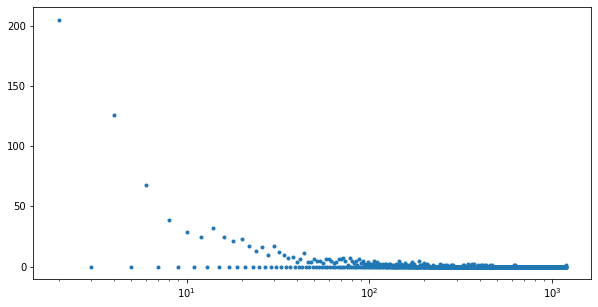

In [13]:
dd = G.degree_distribution()

bins = [b for b in dd.bins()]
plt.figure(figsize=(10, 5))
plt.scatter([l for l, r, b in bins], [b for l, r, b in bins], marker='.');
ax = plt.gca()
ax.set_xscale('log');

# SIR model
### Based on https://github.com/DmitrySerg/COVID-19/blob/master/models/COVID-19.ipynb

In [14]:
from scipy.integrate import odeint


class SIR():
    def __init__(self, pupulation, infected, recovered, beta, gamma):
        """
        N - Total population 
        I0 - Initial number of infected individuals, 
        S0 - Everyone else is susceptible to infection initially
        Contact rate, beta, and mean recovery rate, gamma, (in 1/days)
        """
        self.N = pupulation
        self.I0 = infected
        self.R = recovered
        self.beta = beta
        self.gamma = gamma
        self.S0 = pupulation - infected - recovered

    @staticmethod
    def _deriv(y, t, N, beta, gamma):
        """
        The SIR model differential equations
        """
        S, I, R = y
        dSdt = -beta[int(t)] * S * I / N
        dIdt = beta[int(t)] * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    def run(self, days, startday):
        # Initial conditions vector
        y0 = [self.S0, self.I0, self.R]
        # Integrating the SIR equations over the time grid, t
        t = [d + startday for d in list(range(0, days + 1))]
        # Getting results
        result = odeint(self._deriv, y0, t, args=(self.N, self.beta, self.gamma))
        S, I, R = result.T
        return S, I, R

    @staticmethod
    def plot_results(S, I, R):
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, axisbelow=True)
        ax.plot(S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
        ax.plot(I/1000, 'r', alpha=0.5, lw=2, label='Infected')
        ax.plot(R/1000, 'g', alpha=0.5, lw=2, label='Recovered')
        ax.set_xlabel('Time /days')
        ax.set_ylabel('Number (1000s)')
        ax.yaxis.set_tick_params(length=0)
        ax.xaxis.set_tick_params(length=0)
        ax.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        plt.show()

# City class

In [19]:
from tqdm.notebook import tqdm
from scipy.special import logit, expit

In [15]:
class City():
    def __init__(self, name, population, infected, recovered):
        self.name = name
        self.population = population
        self.infected = infected
        self.recovered = recovered
        
    def _sample_infected(self, n):
        # TODO: make it more realistic (maybe random sampled)
        # TODO: check if it sends more then exists
        return n * self.infected // self.population
    
    def _sample_recovered(self, n):
        # TODO: make it more realistic (maybe random sampled)
        # TODO: check if it sends more then exists
        return n * self.recovered // self.population 
    
    def send_people(self, n):
        assert n < self.population, 'Trying to send more then exists, {}'.format(self.name)
        if n >= self.population:
            return 0, 0, False
        
        inf_t = self._sample_infected(n)
        rec_t = self._sample_recovered(n)
    
        assert n >= (inf_t + rec_t), 'Infected and recovered more then n_passengers, {}, {}, {}, {}'.format(self.name, n, inf_t, rec_t)
        
        self.infected -= inf_t
        self.recovered -= rec_t
        self.population -= n
        if self.population <= 0:
            print(self.name + ' population dropped to {}'.format(self.population))
            self.population = 1
        return max(inf_t, 0), max(rec_t, 0), True
        

# INIT Cities
## Read data

In [16]:
cities = pd.read_csv('../data/cities.csv')
cities.head()

,Unnamed: 0,lat,lng,name,osm_accuracy,population
0,0,52.651055,90.101159,Абаза,0.593508,17111
1,1,53.720902,91.442435,Абакан,0.609791,165183
2,2,53.682800,53.655701,Абдулино,0.587183,20663
3,3,44.864953,38.157819,Абинск,0.597864,34926
4,4,56.525460,52.997251,Агрыз,0.596615,19299


In [17]:
name2population = {name: population for name, population in cities[['name', 'population']].values}

In [18]:
infected = pd.read_csv('../data/cities_infection.csv')
name2infected = {n: i for n, i in infected[['name', 'Infection_22_03']].values}

# Set params

In [20]:
DAYS = 180
max_R0 = 4
min_R0 = 1.

beta = expit(np.linspace(-5, 3, num=DAYS))[::-1]
beta = beta * (max_R0 - min_R0) + min_R0
beta = np.concatenate((beta, np.repeat(beta[-1], 400-len(beta))))

# TODO: choose realistic numbers
contact_rate, recovery_rate = beta/ 18, 1./20

# Simulation itself

In [22]:
%%time
id2City = {i: City(name, name2population[name],
                   name2infected.get(name, 0), 0) for i, name in id2name.items()}
rows = []
def dumper(niter, cid, cname, s, i, r):
    '''Function to save simulation process'''
    rows.append((niter, cid, cname, s, i, r))

NITER = DAYS # Days
for day in tqdm(range(NITER)):
    for city_id in G.vs:
        # update SIR
        city = id2City[city_id.index]
        
#         if (city.infected + city.recovered) >= city.population:
#             print(city.population, city.recovered, city.infected, city.name)
#             assert False, 'Look above'

        sir = SIR(city.population - city.infected - city.recovered,
                  city.infected, city.recovered,
                  contact_rate, recovery_rate)
        S, I, R = sir.run(1, day)

        city.infected = I[1]
        city.recovered = R[1]

        # save step result for sity
        dumper(day, city_id.index, city.name, S[1], I[1], R[1])

        # send
        # for every departure sample number of infected and recovered
        # Turn off cycle below to stop flights simulation
    
    for city_id in G.vs:
        city = id2City[city_id.index]
        
        # Uncomment below to isolate capitals
#         if city.name in {'Москва', 'Санкт-Петербург'}:
#             continue
        for dest_city_id in G.successors(city_id):
            edge_id = G.get_eid(city_id.index, dest_city_id)

            # TODO: split by individual vehicles
            ntravelers = G.es['weight'][edge_id]

            if ntravelers == 0 or ntravelers >= city.population:
                continue
            
        
            dest_city = id2City[dest_city_id]
            # Uncomment below to isolate capitals
#             if dest_city.name in {'Москва', 'Санкт-Петербург'}:
#                 continue            
            inf_t, rec_t, are_sent = city.send_people(ntravelers)
    
            # receive
            if are_sent:
                dest_city.infected += inf_t
                dest_city.recovered += rec_t
                dest_city.population += ntravelers
        


CPU times: user 3min 58s, sys: 260 ms, total: 3min 59s
Wall time: 3min 59s


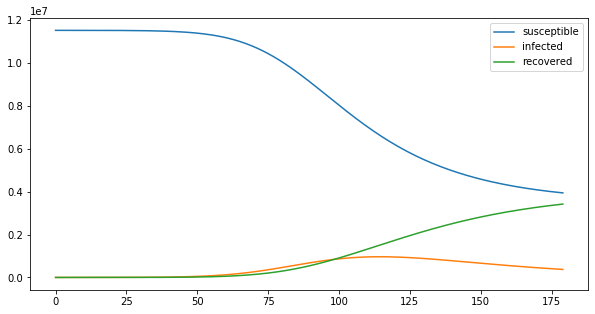

In [23]:
dumpdf = pd.DataFrame(rows, columns=['n_iter', 'city_id', 'name',
                                     'susceptible', 'infected', 'recovered'])

plt.figure(figsize=(10, 5))
mask = dumpdf['name'] == 'Москва'
plt.plot(dumpdf[mask]['n_iter'].values, dumpdf[mask]['susceptible'].values, label='susceptible')
plt.plot(dumpdf[mask]['n_iter'].values, dumpdf[mask]['infected'].values, label='infected')
plt.plot(dumpdf[mask]['n_iter'].values, dumpdf[mask]['recovered'].values, label='recovered');
plt.legend();